In [1]:
import numpy as np
from gearbox_model import RxGearboxModel, TxGearboxModel
import matplotlib.pyplot as plt

## Tx Gearbox

In [2]:

n_frames = 100
header = [[f'{y:02d}-H0{x}' for x in range(2)] for y in range(n_frames)]
data = [[f'{y:02d}-D{x:02d}' for x in range(64)] for y in range(n_frames)]


txg = TxGearboxModel('str')
txg_odata = []

print(txg.get_state_header())

for h, d in zip(header, data):
    for _ in range(2):
        idata = d[32:] if txg.get_frame_word() else d[:32]
        ret = txg.next(h, idata)
        txg_odata.append(ret['data'])
        print(txg.get_state())

        if (ret['pause']):
            ret = txg.next(h, idata)
            txg_odata.append(ret['data'])
            print(txg.get_state())

count	pause	header?	header_idx	data_idx	frame_word	odata
000	False	1	00	02	0	['00-H00', '00-H01', '00-D00', '00-D01', '00-D02', '00-D03', '00-D04', '00-D05', '00-D06', '00-D07', '00-D08', '00-D09', '00-D10', '00-D11', '00-D12', '00-D13', '00-D14', '00-D15', '00-D16', '00-D17', '00-D18', '00-D19', '00-D20', '00-D21', '00-D22', '00-D23', '00-D24', '00-D25', '00-D26', '00-D27', '00-D28', '00-D29']
001	False	0	-1	02	1	['00-D30', '00-D31', '00-D32', '00-D33', '00-D34', '00-D35', '00-D36', '00-D37', '00-D38', '00-D39', '00-D40', '00-D41', '00-D42', '00-D43', '00-D44', '00-D45', '00-D46', '00-D47', '00-D48', '00-D49', '00-D50', '00-D51', '00-D52', '00-D53', '00-D54', '00-D55', '00-D56', '00-D57', '00-D58', '00-D59', '00-D60', '00-D61']
002	False	1	02	04	0	['00-D62', '00-D63', '01-H00', '01-H01', '01-D00', '01-D01', '01-D02', '01-D03', '01-D04', '01-D05', '01-D06', '01-D07', '01-D08', '01-D09', '01-D10', '01-D11', '01-D12', '01-D13', '01-D14', '01-D15', '01-D16', '01-D17', '01-D18', '01-D19', 

## Rx Gearbox - no slip

In [3]:
rxg = RxGearboxModel('str')

rxg_oheader =[]
rxg_odata = []

for id in txg_odata:
    ret = rxg.next(id)
    print(rxg.get_state())

    if ret['header_valid']:
        rxg_oheader.append(ret['header'])

    if ret['data_valid']:
        rxg_odata.append(ret['data'])

000	0	False	0	00	['00-H00', '00-H01']	['XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX']
001	0	True	1	32	['00-H00', '00-H01']	['00-D00', '00-D01', '00-D02', '00-D03', '00-D04', '00-D05', '00-D06', '00-D07', '00-D08', '00-D09', '00-D10', '00-D11', '00-D12', '00-D13', '00-D14', '00-D15', '00-D16', '00-D17', '00-D18', '00-D19', '00-D20', '00-D21', '00-D22', '00-D23', '00-D24', '00-D25', '00-D26', '00-D27', '00-D28', '00-D29', '00-D30', '00-D31']
002	0	True	0	64	['01-H00', '01-H01']	['00-D32', '00-D33', '00-D34', '00-D35', '00-D36', '00-D37', '00-D38', '00-D39', '00-D40', '00-D41', '00-D42', '00-D43', '00-D44', '00-D45', '00-D46', '00-D47', '00-D48', '00-D49', '00-D50', '00-D51', '00-D52', '00-D53', '00-D54', '00-D55', '00-D56', '00-D57', '00-D58', '00-D59', '00-D60', '00-D61', '00-D62', '00-D63']
003	0	True	1	30	['01-

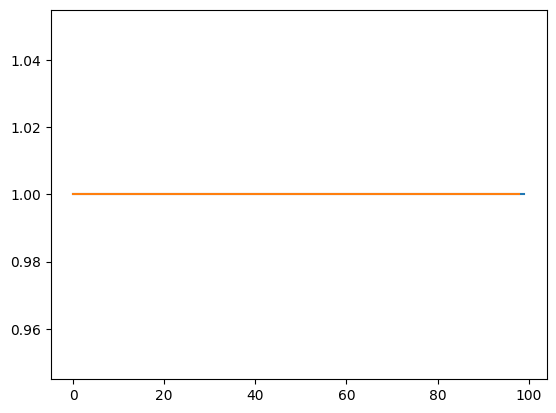

In [4]:
# check the data

# stitch the data back together in to frames



oframes = [list(np.concatenate([x,y])) for x,y in zip(rxg_odata[::2], rxg_odata[1::2])]


head_match = [ih == oh for ih, oh in zip(header, rxg_oheader)]
data_match = [id == od for id, od in zip(data, oframes)]

plt.plot(head_match)
plt.plot(data_match)

## Rx Gearbox - half slip needed

In [5]:
# try with 1 slip out
rx_idata = txg_odata.copy()
rx_idata = [item for sublist in rx_idata for item in sublist]
for _ in range(1): rx_idata.insert(0, 'XXX')

def chunks(lst, n):
    """Yield successive n-sized chunks from lst."""
    for i in range(0, len(lst), n):
        yield lst[i:i + n]

rx_idata = list(chunks(rx_idata, 32))[:-1]

In [44]:
rxg = RxGearboxModel('str')
slip_next = False

rxg_oheader = []
rxg_odata = []

for id in rx_idata:
    ret = rxg.next(id, slip_next)
    print(rxg.get_state())
    slip_next = ret['header_valid'] and 'H0' not in ret['header'][0] and 'H1' not in ret['header'][1]

    if ret['header_valid']:
        rxg_oheader.append(ret['header'])

    if ret['data_valid']:
        rxg_odata.append(ret['data'])

000	0	False	0	00	['XXX', '00-H00']	['XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX', 'XXX']
001	0	True	1	32	['XXX', '00-H00']	['00-H01', '00-D00', '00-D01', '00-D02', '00-D03', '00-D04', '00-D05', '00-D06', '00-D07', '00-D08', '00-D09', '00-D10', '00-D11', '00-D12', '00-D13', '00-D14', '00-D15', '00-D16', '00-D17', '00-D18', '00-D19', '00-D20', '00-D21', '00-D22', '00-D23', '00-D24', '00-D25', '00-D26', '00-D27', '00-D28', '00-D29', '00-D30']
002	1	True	0	64	['00-D63', '01-H00']	['00-D31', '00-D32', '00-D33', '00-D34', '00-D35', '00-D36', '00-D37', '00-D38', '00-D39', '00-D40', '00-D41', '00-D42', '00-D43', '00-D44', '00-D45', '00-D46', '00-D47', '00-D48', '00-D49', '00-D50', '00-D51', '00-D52', '00-D53', '00-D54', '00-D55', '00-D56', '00-D57', '00-D58', '00-D59', '00-D60', '00-D61', '00-D62']
002	0	True	0	64	['01-D30', 